In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

symbol = "BZ=F"
start_date = "2011-06-13"
end_date = "2025-06-25"

df_raw = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
df_raw.dropna(inplace=True)

# Change folder import
emb = pd.read_csv('embeddings_feature_ST.csv', parse_dates=['date']).set_index('date')
sent = pd.read_csv('daily_sent.csv', parse_dates=['Date']).set_index('Date')

emb_aligned = emb.reindex(df_raw.index).ffill().bfill()
sent_aligned = sent.reindex(df_raw.index).ffill().bfill()

df_raw['SENT_1'] = emb_aligned['embedding_3d_1_mean']
df_raw['SENT_2'] = emb_aligned['embedding_3d_2_mean']
df_raw['SENT_3'] = emb_aligned['embedding_3d_3_mean']
df_raw['cosine_sim'] = emb_aligned['cosine_sim']
df_raw['drift'] = emb_aligned['drift']
df_raw['drift_velocity'] = emb_aligned['drift_velocity']
df_raw['drift_velocity_diff'] = emb_aligned['drift_velocity_diff']
df_raw['drift_acceleration'] = emb_aligned['drift_acceleration']
df_raw['var_3d_1'] = emb_aligned['embedding_3d_1_var_daily']
df_raw['var_3d_2'] = emb_aligned['embedding_3d_2_var_daily']
df_raw['var_3d_3'] = emb_aligned['embedding_3d_3_var_daily']
df_raw['sentiment'] = sent_aligned['avg_score']

features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_raw[features_to_scale])
df_scaled = pd.DataFrame(scaled_values, columns=features_to_scale, index=df_raw.index)

def create_sequences_multifeature(df_scaled, input_len=64, output_len=8, target_col='Close'):
    window_size = input_len + output_len
    data = df_scaled.values
    col_idx = df_scaled.columns.get_loc(target_col)

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+window_size, col_idx])

    return np.array(X), np.array(y)

input_len = 64
output_len = 8
X, y = create_sequences_multifeature(df_scaled, input_len, output_len)
print(f"Shape X: {X.shape}, Shape y: {y.shape}")


/tmp/ipython-input-4-2566149818.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed


Shape X: (3430, 64, 5), Shape y: (3430, 8)


In [5]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=5, latent_dim=16, hidden_dim=64, num_layers=1):
        super().__init__()
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.encoder_fc = nn.Linear(hidden_dim * 2, latent_dim)  # bidirezionale

        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * 2)
        self.decoder_lstm = nn.LSTM(hidden_dim * 2, input_dim, num_layers, batch_first=True, bidirectional=False)

    def forward(self, x):
        enc_out, (h_n, c_n) = self.encoder_lstm(x)
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)  # concat bidirezionale
        z = self.encoder_fc(h_n)

        dec_in = self.decoder_fc(z).unsqueeze(1).repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder_lstm(dec_in)
        return dec_out, z

class TransformerPredictor(nn.Module):
    def __init__(self, latent_dim=16, output_len=8, nhead=2, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(latent_dim, output_len)

    def forward(self, x):
        x = x.unsqueeze(0)  # seq_len=1 per transformer
        x = self.transformer_encoder(x)
        x = x.squeeze(0)
        out = self.fc_out(x)
        return out

In [6]:
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

In [7]:
def train_model(autoencoder, transformer, train_loader, val_loader, epochs=20, lr=1e-3):
    ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    tr_optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    val_maes, val_rmses = [], []

    for epoch in range(epochs):
        autoencoder.train()
        transformer.train()
        train_loss = 0

        for xb, yb in train_loader:
            yb = yb.squeeze(-1)
            ae_optimizer.zero_grad()
            tr_optimizer.zero_grad()

            out_ae, z = autoencoder(xb)
            loss_ae = criterion(out_ae, xb)

            y_pred = transformer(z)
            loss_tr = criterion(y_pred, yb)

            loss = loss_ae + loss_tr
            loss.backward()
            ae_optimizer.step()
            tr_optimizer.step()

            train_loss += loss.item()

        val_mse, val_mae, val_rmse, val_r2 = evaluate_model(autoencoder, transformer, val_loader)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_mse)
        val_maes.append(val_mae)
        val_rmses.append(val_rmse)

        print(f"Epoch {epoch+1}/{epochs} Train Loss: {train_losses[-1]:.6f} Val MSE: {val_mse:.6f} Val MAE: {val_mae:.6f} Val RMSE: {val_rmse:.6f} Val R2: {val_r2:.6f}")

    return train_losses, val_losses, val_maes, val_rmses


def evaluate_model(autoencoder, transformer, data_loader):
    autoencoder.eval()
    transformer.eval()
    all_y_true = []
    all_y_pred = []
    with torch.no_grad():
        for xb, yb in data_loader:
            yb = yb.squeeze(-1)
            out_ae, z = autoencoder(xb)
            y_pred = transformer(z)
            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())
    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)
    return compute_metrics(y_true, y_pred)


In [8]:
def prepare_dataloaders(X, y, batch_size=64, split_ratios=(0.6, 0.1, 0.3)):
    num_samples = X.shape[0]
    train_end = int(num_samples * split_ratios[0])
    val_end = int(num_samples * (split_ratios[0] + split_ratios[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def to_tensor_dataset(X_, y_):
        return TensorDataset(torch.tensor(X_, dtype=torch.float32).to(device),
                             torch.tensor(y_, dtype=torch.float32).to(device))

    train_loader = DataLoader(to_tensor_dataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(to_tensor_dataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(to_tensor_dataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = prepare_dataloaders(X, y)

In [9]:
autoencoder = LSTMAutoencoder(input_dim=X.shape[2]).to(device)
transformer = TransformerPredictor().to(device)

train_losses, val_losses, val_maes, val_rmses = train_model(autoencoder, transformer, train_loader, val_loader, epochs=20)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 Train Loss: 0.251179 Val MSE: 0.065367 Val MAE: 0.221187 Val RMSE: 0.255670 Val R2: -3.833811
Epoch 2/20 Train Loss: 0.065940 Val MSE: 0.008203 Val MAE: 0.066777 Val RMSE: 0.090572 Val R2: 0.393273
Epoch 3/20 Train Loss: 0.023595 Val MSE: 0.005396 Val MAE: 0.050397 Val RMSE: 0.073454 Val R2: 0.601026
Epoch 4/20 Train Loss: 0.013932 Val MSE: 0.005257 Val MAE: 0.057691 Val RMSE: 0.072507 Val R2: 0.611194
Epoch 5/20 Train Loss: 0.010209 Val MSE: 0.003547 Val MAE: 0.043407 Val RMSE: 0.059555 Val R2: 0.737733
Epoch 6/20 Train Loss: 0.007954 Val MSE: 0.004017 Val MAE: 0.042565 Val RMSE: 0.063377 Val R2: 0.703030
Epoch 7/20 Train Loss: 0.007236 Val MSE: 0.002931 Val MAE: 0.037169 Val RMSE: 0.054138 Val R2: 0.783321
Epoch 8/20 Train Loss: 0.007335 Val MSE: 0.005418 Val MAE: 0.053729 Val RMSE: 0.073605 Val R2: 0.599379
Epoch 9/20 Train Loss: 0.006583 Val MSE: 0.004297 Val MAE: 0.046247 Val RMSE: 0.065551 Val R2: 0.682282
Epoch 10/20 Train Loss: 0.005903 Val MSE: 0.002384 Val MAE: 0.0

In [10]:
test_mse, test_mae, test_rmse, test_r2 = evaluate_model(autoencoder, transformer, test_loader)
print(f"Test MSE: {test_mse:.6f}, Test MAE: {test_mae:.6f}, Test RMSE: {test_rmse:.6f}, Test R2: {test_r2:.6f}")

Test MSE: 0.001992, Test MAE: 0.033437, Test RMSE: 0.044635, Test R2: 0.838998


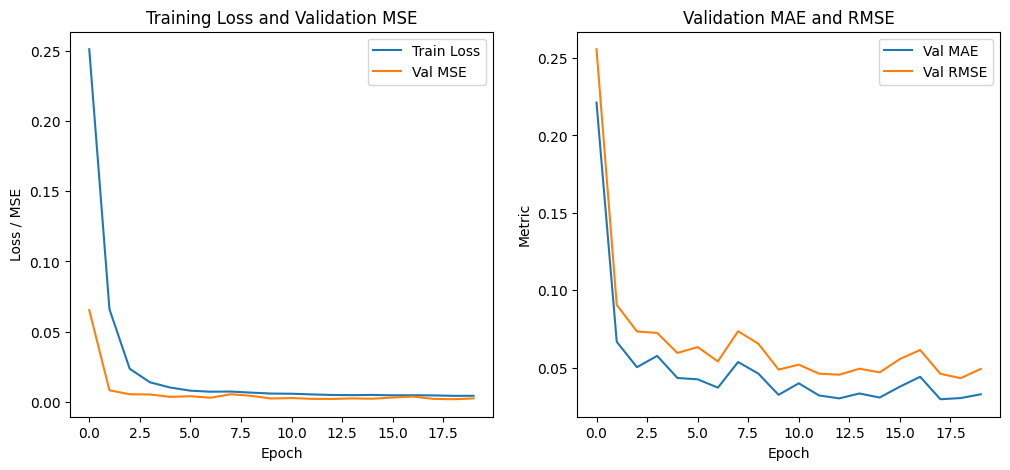

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / MSE')
plt.legend()
plt.title('Training Loss and Validation MSE')

plt.subplot(1,2,2)
plt.plot(val_maes, label='Val MAE')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Validation MAE and RMSE')

plt.show()

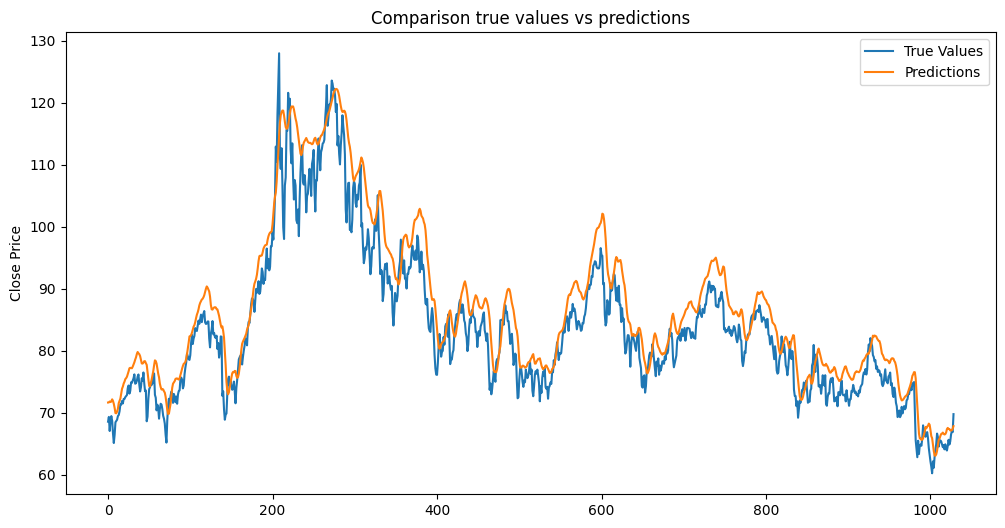

In [12]:
def plot_predictions(autoencoder, transformer, data_loader, scaler, target_col_index=3):
    autoencoder.eval()
    transformer.eval()

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for xb, yb in data_loader:
            yb = yb.squeeze(-1)
            out_ae, z = autoencoder(xb)
            y_pred = transformer(z)

            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)

    min_val = scaler.data_min_[target_col_index]
    scale_val = scaler.data_range_[target_col_index]

    y_true_denorm = y_true * scale_val + min_val
    y_pred_denorm = y_pred * scale_val + min_val

    plt.figure(figsize=(12,6))
    plt.plot(y_true_denorm[:, 0], label='True Values')
    plt.plot(y_pred_denorm[:, 0], label='Predictions')
    plt.title('Comparison true values vs predictions')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_predictions(autoencoder, transformer, test_loader, scaler, target_col_index=3)
